# Laboratorio 7 (Segmentación de Clientes de Banco) - Inteligencia Artificial
Autores: Stefano Aragoni, Carol Arévalo, Luis Santos

### Task 1.0: Exploración y Limpieza de Datos
Como primer paso, se importa el archivo a través de distintas librerías. 

In [1]:
# Importar librerías 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Cargar el dataset
data = pd.read_csv('bank_transactions.csv')

data.head()


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


##### Datos Faltantes
En este caso, se encontro que solo la columna de CustomerDOB tiene un par de datos faltanes.

Index(['CustomerDOB', 'CustGender', 'CustLocation', 'CustAccountBalance'], dtype='object')

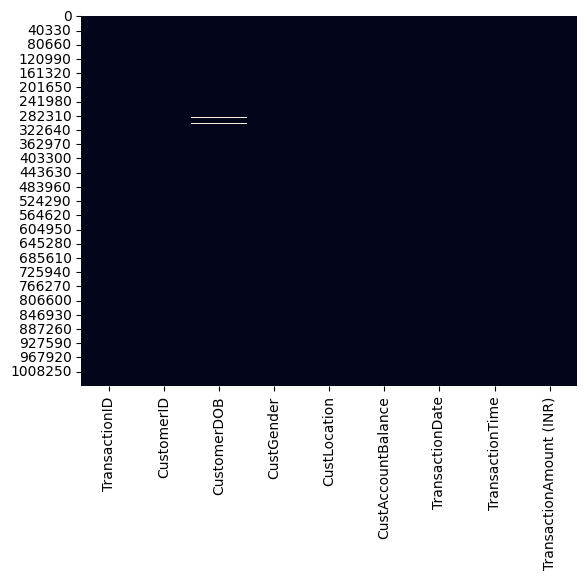

In [2]:
# Matriz de datos faltantes
sns.heatmap(data.isnull(), cbar=False)

# Mostrar columnas con datos faltantes, o con datos fuera de lugar (como un string en columna numérica)
data.columns[data.isnull().any()]

En caso hayan datos faltantes que no se pueden observar en la gráfica, a continuación se realizó un proceso que rellena datos faltantes con promedio de datos.

In [3]:
for col in data.columns[data.isnull().any()]:

    if data[col].dtype == 'float64' or data[col].dtype == 'int64':
        data[col].fillna(data[col].mean(), inplace=True)

    else:
        data[col].fillna(data[col].mode()[0], inplace=True)

data.columns[data.isnull().any()]

Index([], dtype='object')

##### Encoding
Convertir variables que no son numéricas a numéricas. En este caso, principalmente se estaba conviertiendo balance y transacciones. Las fechas se cambiaron a formato de segundos. El resto de datos se convritiron a datos numéricos.

In [4]:
import datetime
from datetime import timedelta, date
from sklearn.preprocessing import LabelEncoder

#-------------------EDAD-------------------------
# Convertir CustomerDOB a año de nacimiento
data['YOB'] = '19' + data['CustomerDOB'].str[-2:]
data['YOB'] = data['YOB'].astype(int)

# Eliminar columna de DOB
data = data.drop(['CustomerDOB'], axis=1)

# Determinar edad
data['Age'] = 2023 - data['YOB']

# Eliminar columna de YOB
data = data.drop(['YOB'], axis=1)

#-------------------GENERO-------------------------
# Convertir genero a int. M = 0, F = 1
data['CustGender'] = data['CustGender'].map({'M': 0, 'F': 1})

#------------ELIMINAR TRANSACTIONS----------------
data = data.drop(['TransactionID'], axis=1)

#-----------------ELIMINAR CID--------------------
data = data.drop(['CustomerID'], axis=1)

#----------ELIMINAR TRANSACTION DATE--------------
data = data.drop(['TransactionDate'], axis=1)
data = data.drop(['TransactionTime'], axis=1)

data.head()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),Age
0,1.0,JAMSHEDPUR,17819.05,25.0,29
1,0.0,JHAJJAR,2270.69,27999.0,66
2,1.0,MUMBAI,17874.44,459.0,27
3,1.0,MUMBAI,866503.21,2060.0,50
4,1.0,NAVI MUMBAI,6714.43,1762.5,35


In [5]:
# Convierte la ubicacion a un numero
le = LabelEncoder()
data["CustLocation"] = le.fit_transform(data["CustLocation"])

data.head()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),Age
0,1.0,3586,17819.05,25.0,29
1,0.0,3648,2270.69,27999.0,66
2,1.0,5268,17874.44,459.0,27
3,1.0,5268,866503.21,2060.0,50
4,1.0,5657,6714.43,1762.5,35


##### Balanceo
Se determino que es importantes que la siguiente variable esté balanceada:

-CustGender: para verificar que exista una cantidad equilibrada de datos para ambos géneros


In [6]:
data2 = data.copy()

In [7]:
from imblearn.over_sampling import SMOTE

#Calcular cuantas columans son F y cuantas M en CustGender
print('Número de F:',data2[data2['CustGender'] == 1].shape[0])
print('Número de M:',data2[data2['CustGender'] == 0].shape[0])
data2 = data2.dropna(subset=['CustGender'])

# Separar las características y la variable objetivo
X_temp = data2.drop('CustGender', axis=1)
y_temp = data2['CustGender']

#Aplicar SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_temp, y_temp)

data2 = pd.concat([X_resampled, y_resampled], axis=1)

# Contar los valores de cada clase
print('Número de F balanceado:',data2[data2['CustGender'] == 1].shape[0])
print('Número de M balanceado:',data2[data2['CustGender'] == 0].shape[0])



ModuleNotFoundError: No module named 'imblearn'

##### Escalar
En este caso, se utilizó la librería de SKLearn para poder escalar y normalizar los datos que lo necesitaran. Asimismo, también se hizo un análisis pre y post escalamiento para determinar la distribución de los datos. En el preprocesamiento, se podía observar cómo ciertas variables tenían una alta desviación estándar a comparación de su respectiva media. Esto fue solucionado a través de la función de MinMaxScaler(). 

> Asimismo, es importante mencionar que la normalización de datos es importante para, según Microsoft, "tener datos que usan una escala común, sin distorsionar las diferencias en los intervalos de valores ni perder información". https://learn.microsoft.com/es-es/azure/machine-learning/component-reference/normalize-data

In [ ]:
# Calcular media y desviación estándar de cada columna
print('\n\nMedia y desviación estándar de cada columna:')
data2.describe()



Media y desviación estándar de cada columna:


,CustLocation,CustAccountBalance,TransactionAmount (INR),Age,CustGender
count,1.533260e+06,1.533260e+06,1.533260e+06,1.533260e+06,1533260.0
mean,4.096867e+03,1.140735e+05,1.594076e+03,4.201333e+01,0.5
std,2.358510e+03,8.532912e+05,6.473038e+03,2.007593e+01,0.5
min,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.0
25%,2.075000e+03,5.278100e+03,1.790000e+02,3.200000e+01,0.0
50%,4.011000e+03,1.805013e+04,4.930000e+02,3.600000e+01,0.5
75%,5.792000e+03,6.111313e+04,1.268000e+03,4.200000e+01,1.0
max,9.354000e+03,1.150355e+08,1.560035e+06,1.230000e+02,1.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data2)
df_feat = pd.DataFrame(scaled_features, columns=data2.columns)
df_feat.head()

,CustLocation,CustAccountBalance,TransactionAmount (INR),Age,CustGender
0,0.383365,0.000155,0.000016,0.050505,1.0
1,0.389994,0.000020,0.017948,0.424242,0.0
2,0.563182,0.000155,0.000294,0.030303,1.0
3,0.563182,0.007532,0.001320,0.262626,1.0
4,0.604768,0.000058,0.001130,0.111111,1.0


##### Selección de Variables

Finalmente, se quiso determinar los 3 features que se estarían utilizando para la realización del modelo de agrupación. En este caso, se quería dividir los clientes de un banco en grupos, para así entender la distribución de los mismos. En este caso, sí o sí se quería utilizar como variable CustAccountBalance; ya que es de interés del banco saber qué grupos de personas tienen la mayor cantidad de dinero en el mismo. 

Por otro lado, otra variable de interés era la edad, para así poder entender cómo el dinero del banco está distribuido entre las personas. 

Cabe destacar que se hizo un análisis de correlación, sin embargo, se pudo determinar que no existe mucha correlación entre las mismas. El top de variables con más correlación a CustAccountBalance son:

1. Age                
2. TransactionAmount (INR)             
3. CustLocation         
4. CustGender              

En este caso se utilizarán las variables que presentan una correlación positiva.

In [ ]:
# Correlación entre las columnas y el status
corr = df_feat.corr()['CustAccountBalance'].sort_values()
print(corr)

CustGender                -0.003968
CustLocation               0.002192
TransactionAmount (INR)    0.053640
Age                        0.094765
CustAccountBalance         1.000000
Name: CustAccountBalance, dtype: float64


----------
### Task 1.1: K -Means

1. Si considera necesario haga split del dataset como en los laboratorios anteriores. Recuerde que es un problema de aprendizaje no supervisado
> AAA 

2.Seleccione el número de clusters que mejor se adapte al dataset. Justifique su elección
> AAA 

3.Investigue sobre Principal Component Analysis (PCA) y responda: ¿Cómo podría ayudarle a mejorar la calidad de sus clusters?
> AAA 

4. Muestre al menos una gráfica que muestre cómo se dividen los clusters seleccionados
> AAA 


5. Seleccione dos features, justifique su elección
> AAA 

6. Puede considerar investigar sobre Principal Component Analysis (PCA)
> AAA 

7. Provea una métrica de desempeño, justificando su elección
> AAA 


#### Implementacion de K-Means
En esta primera sección, se creó manualmente las funciones correspondientes para el funcionamiento del modelo de K-Means

In [ ]:
#modelo K-means

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
import pandas as pd

def initialize_centroids(X, K):
    # Inicializar los centroides al azar a partir de los puntos de datos
    centroids = X[np.random.choice(X.shape[0], K, replace=False), :]
    return centroids

def assign_clusters(X, centroids):
    # Asignar cada punto de datos al clúster más cercano
    distances = np.sqrt(np.sum((X - centroids[:, np.newaxis])**2, axis=2))
    cluster_assignments = np.argmin(distances, axis=0)
    return cluster_assignments

def update_centroids(X, cluster_assignments, K):
    # Calcular nuevos centroides a partir de los puntos de datos en cada clúster
    centroids = np.zeros((K, X.shape[1]))
    for i in range(K):
        centroids[i,:] = np.mean(X[cluster_assignments == i, :], axis=0)
    return centroids

def kmeans(X, K, max_iters=100):
    centroids = initialize_centroids(X, K)
    for i in range(max_iters):
        cluster_assignments = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, cluster_assignments, K)
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    return centroids, cluster_assignments

Posteriormente, se utilizó la función de calculate_WSS para determinar la métrica de WSS de diferentes modelos con distintos valores de clusters. Esto con el propósito de determinar cuántos clusters son los ideales para este modelo.


Al hacer la gráfica "elbow" (codo) se puede determinar que con 3 clusters empieza a normalizarse el WSS y ya no decrece a una velocidad tan rápida. Por tal razón, el modelo final utilizará 3 clusters. 

k: 1 cost: 63135.986563144754
k: 2 cost: 11259.34626332254
k: 3 cost: 4442.057724863965
k: 4 cost: 2449.250961253365
k: 5 cost: 1594.6794825176657
k: 6 cost: 1287.2796710174443
k: 7 cost: 924.5267379890878
k: 8 cost: 819.7257078999697
k: 9 cost: 735.9880196399179
k: 10 cost: 687.2394726901496


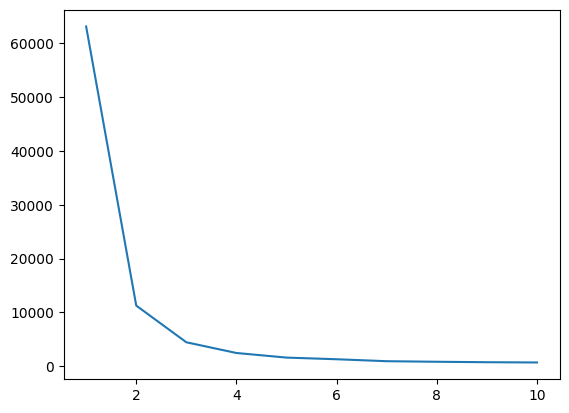

In [ ]:
# Determinar la mejor cnatidad de clusters a través de Within-Cluster Sum of Squares (WSS) 
def calculate_WSS(points, kmax=10):
  sse = []
  for k in range(1, kmax+1):
    centroids, cluster_assignments = kmeans(points, k)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[cluster_assignments[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    print("k:",k, "cost:", curr_sse)
    sse.append(curr_sse)

  return sse


X = df_feat[['Age', 'CustAccountBalance']].values
sse = calculate_WSS(X, kmax=10)

fig = plt.figure()
ax = plt.axes()

x_plot = list(range(1,11))
ax.plot(x_plot, sse)

En base al valor de K determinado anteriormente, se creó una gráfica para poder demostrar las agrupaciones realizadas por el modelo.

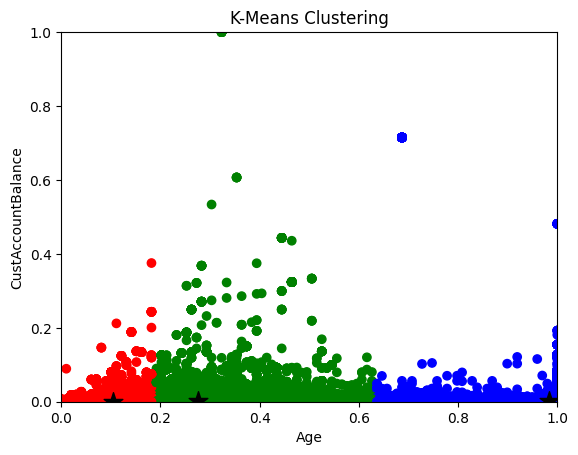

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Calcular los centroides y los índices de asignación de clúster
centroids, cluster_assignments = kmeans(X, K=3)

fig = plt.figure()
ax = fig.add_subplot(111)

# Assign different colors to each cluster
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'b']
cluster_colors = [colors[i] for i in cluster_assignments]

# Plot the data points
ax.scatter(X[:, 0], X[:, 1], c=cluster_colors)

# Plot the centroids
ax.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='*', s=200)

# Set the axis labels
ax.set_xlabel('Age')
ax.set_ylabel('CustAccountBalance')
ax.set_title('K-Means Clustering')

ax.set_xlim([min(X[:, 0]), max(X[:, 0])])
ax.set_ylim([min(X[:, 1]), max(X[:, 1])])

plt.show()

Para finalizar con el análisis del modelo creado manualmente, se quizo determinar la validez del modelo a través de Davies-Bouldin Index. A continuación, como se puede observar, se obtuvo un valor de 0.43. 

Esto es bueno, ya que mientras más bajo es este valor, mejor es la separación entre los clusters. Cabe destacar que el valor máximo promedio de este índice es entre 2 a 3 (pero podría llegar hasta el infinito positivo), por lo cual este valor cercano a 0 es casi que excelente. 

In [ ]:
# Davies-Bouldin Index
from sklearn.metrics import davies_bouldin_score
print(davies_bouldin_score(X, cluster_assignments))

0.4339832355499758


### Implementacion con SK Learn

In [ ]:
from sklearn.cluster import KMeans

# Calcular los centroides y los índices de asignación de clúster
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
centroids = kmeans.cluster_centers_
cluster_assignments = kmeans.labels_

fig = plt.figure()
ax = fig.add_subplot(111)

# Assign different colors to each cluster
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'b']
cluster_colors = [colors[i] for i in cluster_assignments]

# Plot the data points
ax.scatter(X[:, 0], X[:, 1], c=cluster_colors)

# Plot the centroids
ax.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='*', s=200)

# Set the axis labels
ax.set_xlabel('Age')
ax.set_ylabel('CustAccountBalance')
ax.set_title('K-Means Clustering')

ax.set_xlim([min(X[:, 0]), max(X[:, 0])])
ax.set_ylim([min(X[:, 1]), max(X[:, 1])])

plt.show()

# Davies-Bouldin Index
print(davies_bouldin_score(X, cluster_assignments))